In [1]:
using PyPlot
using Random
using LinearAlgebra
using Statistics
using Test

In [2]:
include("power_functions.jl")
include("jacobi_functions.jl")
include("qr_functions.jl")

shiftQRc_hessen (generic function with 2 methods)

### Przygotowanie danych

In [3]:
function make_moon(; n_samples = 100, shuffle = true)
    n_samples_out = n_samples ÷ 2
    n_samples_in = n_samples - n_samples_out

    X = zeros(2,n_samples)
    y = zeros(n_samples)

    # outer circle
    X[1,1:n_samples_out] = cos.(LinRange(0, π, n_samples_out))
    X[2,1:n_samples_out] = sin.(LinRange(0, π, n_samples_out))
    y[1:n_samples_out] .= 0

    # inner circle
    X[1,n_samples_out+1:end] = 1 .- cos.(LinRange(0, π, n_samples_in))
    X[2,n_samples_out+1:end] = 1 .- sin.(LinRange(0, π, n_samples_in)) .- 0.5
    y[n_samples_out+1:end] .= 1

    if shuffle
       ind = randperm(n_samples)
       return X[:,ind],y[ind]
    else
       return X,y
    end
end

N = 100
X,y = make_moon(n_samples = N)

([0.008209986176753836 1.8014136218679564 … 0.15959989503337932 1.9672948630390295; 0.372122838315494 -0.0981105304912161 … 0.9871817834144501 0.24634541609049265], [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0  …  1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

In [4]:
PyPlot.plt.rc("image", cmap = "RdYlBu_r")

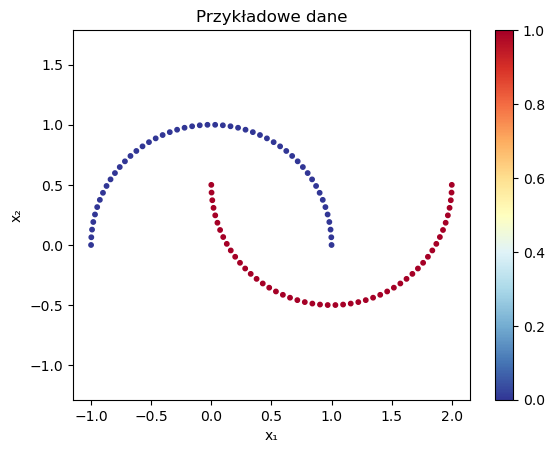

In [5]:
title("Przykładowe dane")
scatter(X[1,:],X[2,:],10,y); colorbar();
xlabel("x₁")
ylabel("x₂")
axis("equal");

### Metoda SVD na podstawie algorytmu Grama-Schmidta

In [6]:
function my_svd(A::Matrix; maxiter=1000)
    V = randn(size(A,2), size(A,1)) # random initialization
    for _ = 1:maxiter
        W = A * V
        Z = A' * W
        V, R = mgramschmidt(Z)
    end
    W = A * V
    S = [norm(W[:, i]) for i=1:size(W,2)] # singular values
    U = reduce(hcat,[W[:,i]/S[i] for i=1:size(W,2)]) # left singular vectors
    return U, S, V
end

my_svd (generic function with 1 method)

In [7]:
Xa = X .- mean(X,dims=2);
U,Σ,V = my_svd(Xa);

@test Xa ≈ U * Diagonal(Σ) * V'

Test Passed

### Klasyczna metoda PCA na podstawie własnego algorytmu wyznaczania wartości własnych

In [8]:
function my_pca(A::Matrix; maxiter=1000)
    C = A .- mean(A);
    Λ, V = jacobi_B_vect(cov(C'), maxiter);
    W = V;
    P = W * A;
end

my_pca (generic function with 1 method)

PCA - Dane Iris

In [9]:
using RDatasets
iris = dataset("datasets", "iris");

In [10]:
Xtr = convert(Array,(iris[1:2:end,1:4]));
Xtr_labels = convert(Array,(iris[1:2:end,5]));
Xtr = hcat(Xtr');

In [11]:
X_pca = my_pca(Xtr, maxiter=250)

4×75 Matrix{Float64}:
  0.763505   0.72914   0.684942   0.708292  …   5.28502   4.85379   4.80381
  1.5442     1.41032   1.64585    1.63323       3.37853   2.58508   3.44395
 -2.30237   -2.11161  -2.24804   -1.98242      -1.84891  -2.10107  -1.72232
  5.65611    5.20389   5.63279    5.26031       7.19414   6.31614   6.82248

In [12]:
setosa = Xtr[:,Xtr_labels.=="setosa"];
versicolor = Xtr[:,Xtr_labels.=="versicolor"];
virginica = Xtr[:,Xtr_labels.=="virginica"];

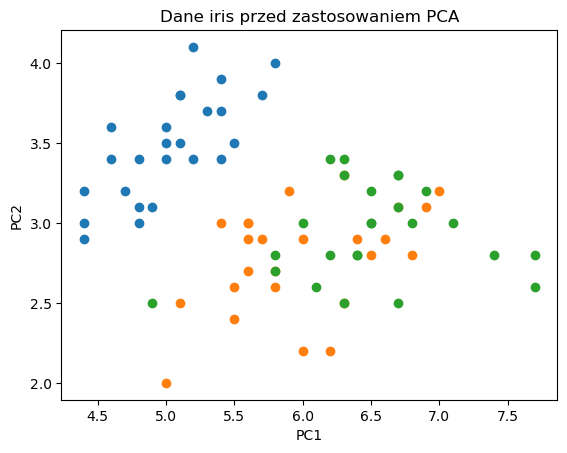

PyObject Text(24.000000000000007, 0.5, 'PC2')

In [13]:
title("Dane iris przed zastosowaniem PCA")
scatter(setosa[1,:],setosa[2,:])
scatter(versicolor[1,:],versicolor[2,:])
scatter(virginica[1,:],virginica[2,:])
xlabel("PC1")
ylabel("PC2")

In [14]:
X_pca = my_pca(Xtr, maxiter=100)
setosa = X_pca[:,Xtr_labels.=="setosa"];
versicolor = X_pca[:,Xtr_labels.=="versicolor"];
virginica = X_pca[:,Xtr_labels.=="virginica"];

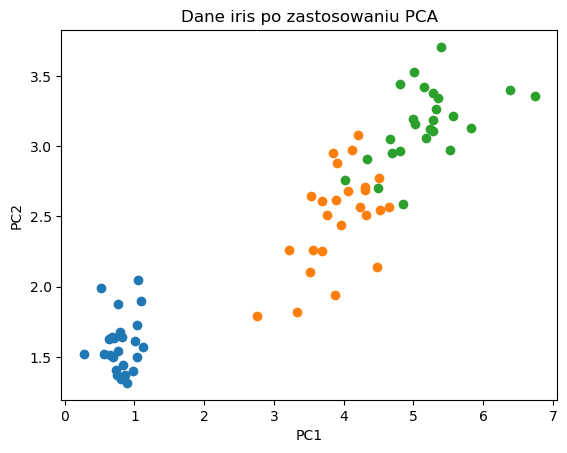

PyObject Text(24.000000000000007, 0.5, 'PC2')

In [15]:
title("Dane iris po zastosowaniu PCA")
scatter(setosa[1,:],setosa[2,:])
scatter(versicolor[1,:],versicolor[2,:])
scatter(virginica[1,:],virginica[2,:])
xlabel("PC1")
ylabel("PC2")

### Metoda PCA wykorzystująca jądro RBF na podstawie własnego algorytmu wyznaczania wartości własnych

In [16]:
γ = 15
kernel(x,y) = exp( - γ * sum( (x - y).^2) )

kernel (generic function with 1 method)

In [17]:
function kernel_PCA(X,kernel,ncomp)
    N = size(X,2)
    K = zeros(N,N)

   for j = 1:N
      for i = 1:N
        K[i,j] = kernel(X[:,i],X[:,j])
      end
    end
    one_n = ones(N,N)/N
    # recenter K
    Kp = Symmetric(K - one_n * K - K * one_n + one_n * K * one_n)
    Kp = convert(Matrix, Kp)
    
    Λ, V = jacobi_B_vect(Kp, 10000);

    V = V[:, end-ncomp+1:end];
    V = reverse(V, dims=2)
    Λ = Λ[end-ncomp+1:end]
    Λ = reverse(Λ)

    Λ[Λ .< 0] .= 0
    λ = Λ/N
    amplitudes = Diagonal(sqrt.(Λ)) * V';

    return amplitudes, Λ, V, K
end

kernel_PCA (generic function with 1 method)

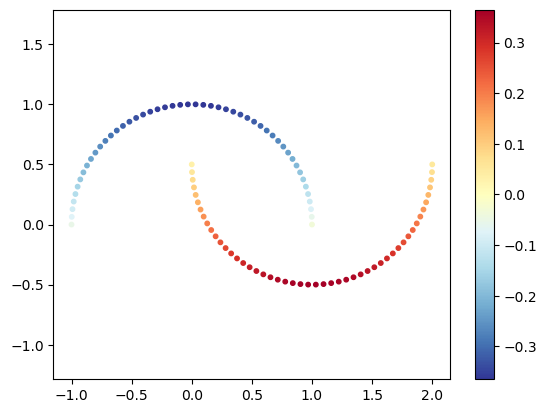

In [18]:
ncomp = 2
amplitudes, Λ, V, K = kernel_PCA(X,kernel,ncomp)

scatter(X[1,:],X[2,:],10,amplitudes[1,:])
axis("equal")
colorbar();

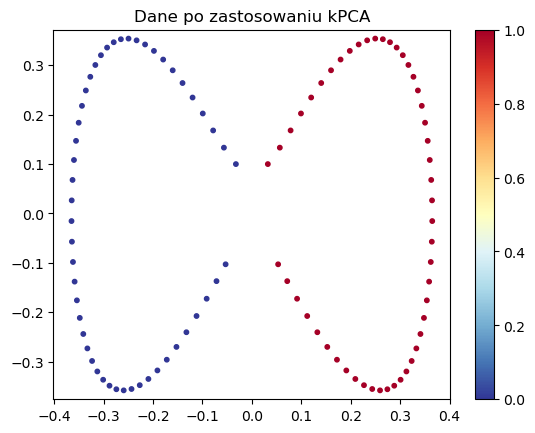

In [19]:
title("Dane po zastosowaniu kPCA")
scatter(amplitudes[1,:],amplitudes[2,:],10,y)
axis("equal")
colorbar();

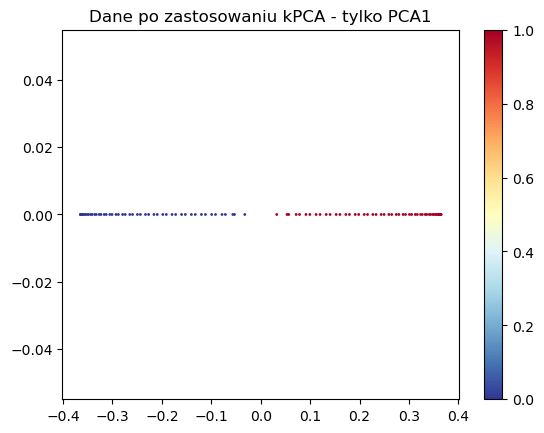

In [20]:
title("Dane po zastosowaniu kPCA - tylko PCA1")
scatter(amplitudes[1,:],zeros(N),1,y); colorbar();

### Klasyczne PCA dla danych półksiężyca

In [21]:
X_pca = my_pca(X, maxiter=1000)

2×100 Matrix{Float64}:
 -0.351655  0.646094  -0.988535  -0.961112  …  -0.323369  -0.890598  0.369149
  0.12199   1.68442    0.150989   0.27616       0.946273   0.454792  1.94799

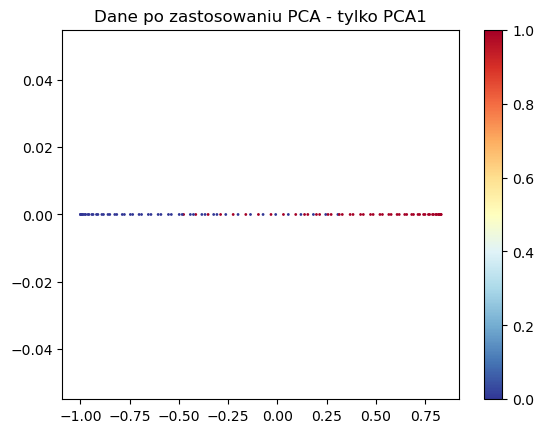

In [22]:
title("Dane po zastosowaniu PCA - tylko PCA1")
scatter(X_pca[1,:],zeros(N),1,y); colorbar();